# Exploring the effect of class imbalance on model performance

Starting with the Titanic dataset as a balanced one, we will make the training data more and more imbalanced to show the effects of trying to train with fewer and fewer positive samples.

In [2]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from collections import Counter

%matplotlib inline

from src.preprocessing import preprocessor_pipeline, rebalance_dataset
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
)

%load_ext lab_black

In [3]:
with open("src/params.json", "r") as file:
    model_params = json.load(file)

In [4]:
params = model_params["model_parameters"]

## Load data and split into train/val

In [5]:
train_df = pd.read_csv("data/train.csv")

train_df, val_df = train_test_split(
    train_df, test_size=0.1, random_state=1, stratify=train_df["Survived"]
)
train_df, val_df = (train_df.copy(), val_df.copy())

In [6]:
label = "Survived"

# Main training loop

In [7]:
ratios = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 2, 3, 4, 5, 10, 20, 50]

Ratio 1 - df shape (614, 12)


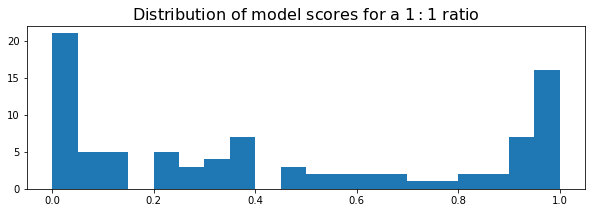

Ratio 1.1 - df shape (645, 12)


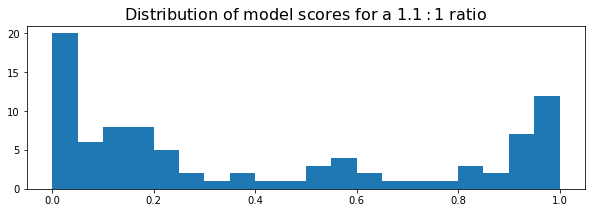

Ratio 1.2 - df shape (675, 12)


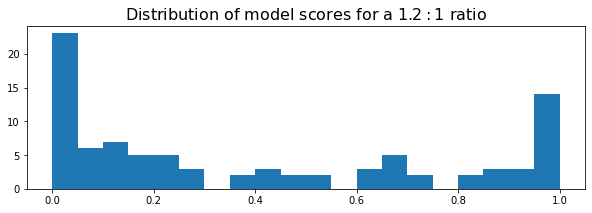

Ratio 1.3 - df shape (706, 12)


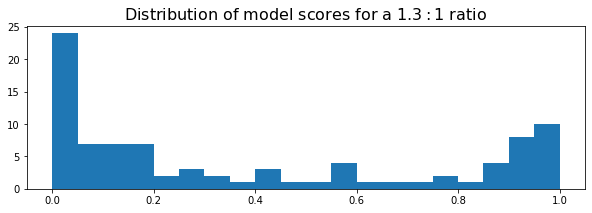

Ratio 1.4 - df shape (737, 12)


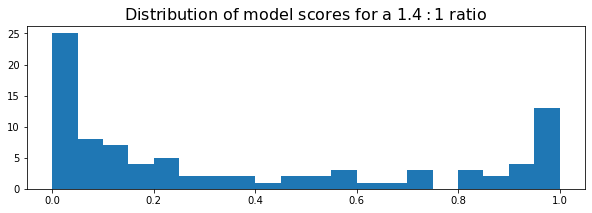

Ratio 1.5 - df shape (767, 12)


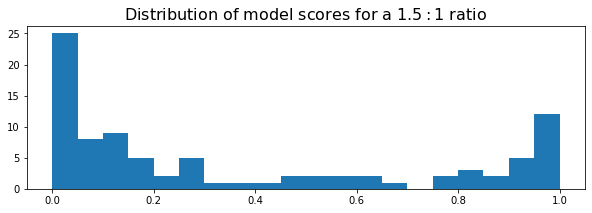

Ratio 2 - df shape (741, 12)


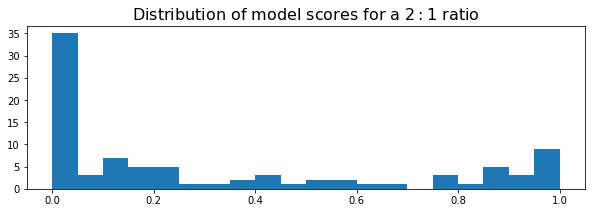

Ratio 3 - df shape (659, 12)


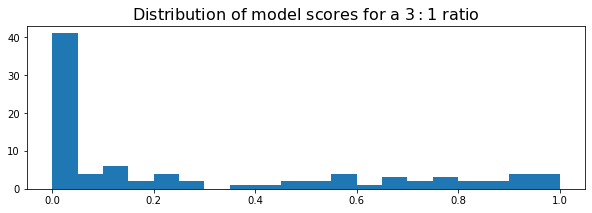

Ratio 4 - df shape (618, 12)


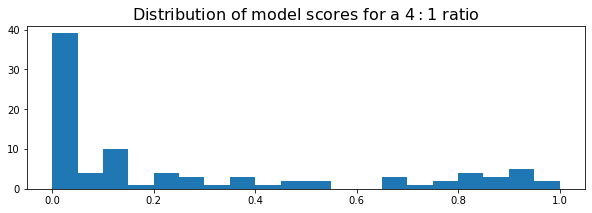

Ratio 5 - df shape (593, 12)


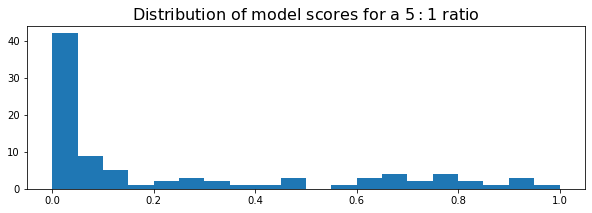

Ratio 10 - df shape (543, 12)


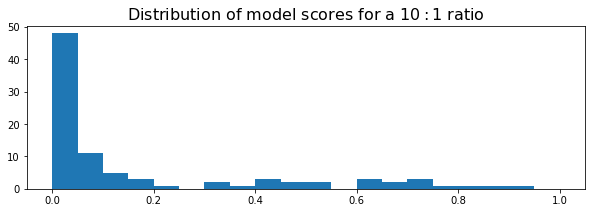

Ratio 20 - df shape (519, 12)


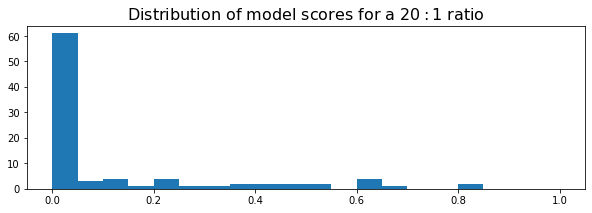

Ratio 50 - df shape (504, 12)


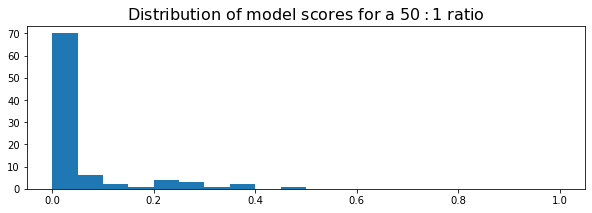

In [13]:
df_dict = dict()

X_train_dict = dict()
y_train_dict = dict()
model_dict = dict()
scores_dict = dict()

# instantiate the preprocessor
preprocessor = preprocessor_pipeline(scaling=True)

# define feature types
categorical_fts = ["Pclass", "Embarked", "Sex"]
numerical_fts = ["Age", "Fare"]
input_features = numerical_fts + categorical_fts

for ratio in ratios:
    df_balanced = rebalance_dataset(train_df, label, ratio)
    df_dict[ratio] = df_balanced
    print(f"Ratio {ratio} - df shape {df_dict[ratio].shape}")

    # transform the data
    X_train_dict[ratio] = preprocessor.fit_transform(df_balanced[input_features])
    y_train_dict[ratio] = df_balanced[label].values

    # sort out the validation data
    val_tf = preprocessor.transform(val_df[input_features])
    val_y = val_df[label].values

    # train the model
    clf = RandomForestClassifier(**params)
    trained_model = clf.fit(X_train_dict[ratio], y_train_dict[ratio])
    model_dict[ratio] = trained_model

    # get the scores
    scores = clf.predict_proba(val_tf)[:, 1]
    scores_dict[ratio] = scores
    # get the true values
    y_hat = np.where(scores, 1, 0)

    plt.figure(figsize=(10, 3))
    plt.hist(scores, bins=[0.05 * x for x in range(21)])
    plt.title(f"Distribution of model scores for a ${ratio}:1$ ratio", fontsize=16)
    plt.show()

## Validation

In [30]:
print(classification_report(val_y, y_hat))
print(confusion_matrix(val_y, y_hat))

              precision    recall  f1-score   support

           0       0.67      0.07      0.13        55
           1       0.39      0.94      0.55        35

    accuracy                           0.41        90
   macro avg       0.53      0.51      0.34        90
weighted avg       0.56      0.41      0.30        90

[[ 4 51]
 [ 2 33]]


In [31]:
print("Accuracy - {:.3f}".format(accuracy_score(val_y, y_hat)))
print("Precision - {:.3f}".format(precision_score(val_y, y_hat)))
print("Recall - {:.3f}".format(recall_score(val_y, y_hat)))

Accuracy - 0.411
Precision - 0.393
Recall - 0.943
